# Constrained Variational Autoencoder

Suppose we are given data $(x_i)_{i=1}^m$ and $(y_i)_{i=1}^m$, for example class labels or parts of $x_i$. The goal is to get an estimate for the conditional distribution $p(x|y)$. This can be very useful if we have missing data in an image and would like to inpaint the missing parts. 

This can be done in the same way as for variational autoencoders, only that the networks $Q$ and $P$ operate on both $x$ and $y$.

Then, the goal is to construct the encoding net so that the resulting probabilistic has a Gaussian distribution and the decoder reconstructs the original data.

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
Iter: 0
Loss: 726.6
()


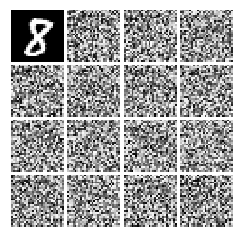

Iter: 1000
Loss: 135.0
()


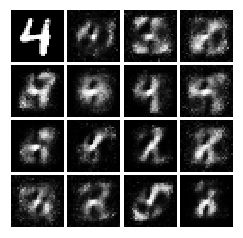

Iter: 2000
Loss: 115.4
()


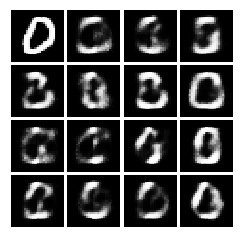

Iter: 3000
Loss: 110.8
()


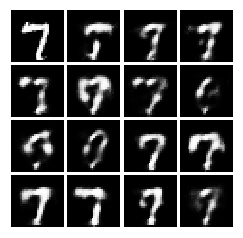

Iter: 4000
Loss: 105.4
()


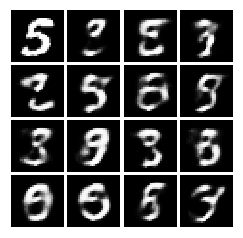

Iter: 5000
Loss: 107.6
()


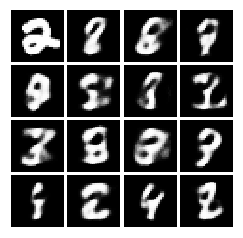

Iter: 6000
Loss: 103.8
()


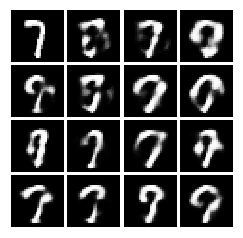

Iter: 7000
Loss: 103.6
()


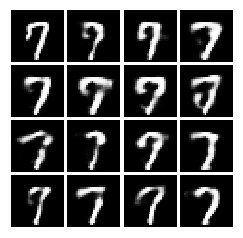

Iter: 8000
Loss: 100.9
()


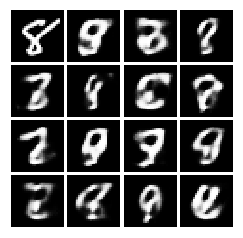

Iter: 9000
Loss: 98.8
()


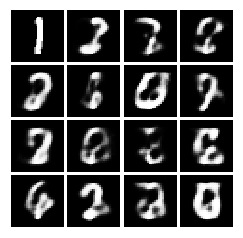

Iter: 10000
Loss: 101.6
()


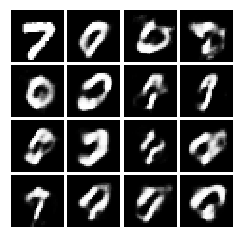

Iter: 11000
Loss: 106.0
()


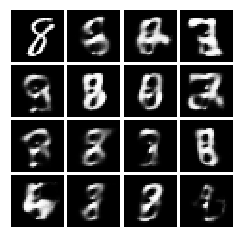

Iter: 12000
Loss: 95.37
()


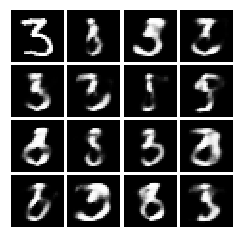

Iter: 13000
Loss: 102.7
()


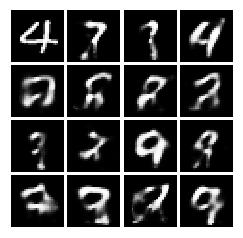

Iter: 14000
Loss: 102.2
()


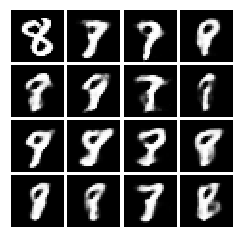

Iter: 15000
Loss: 101.1
()


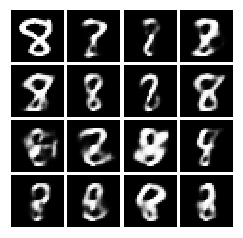

Iter: 16000
Loss: 102.0
()


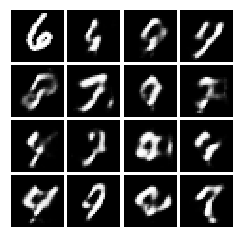

Iter: 17000
Loss: 98.6
()


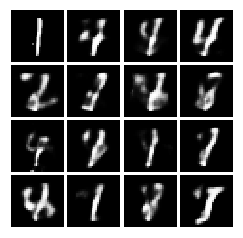

Iter: 18000
Loss: 96.89
()


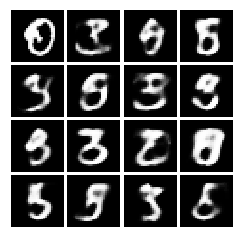

Iter: 19000
Loss: 99.16
()


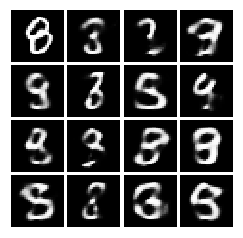

Iter: 20000
Loss: 96.13
()


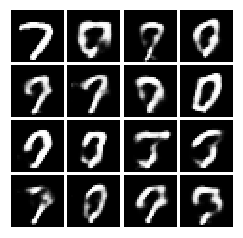

Iter: 21000
Loss: 98.2
()


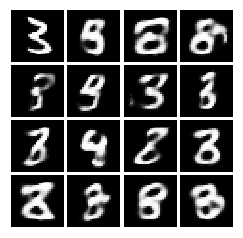

Iter: 22000
Loss: 104.9
()


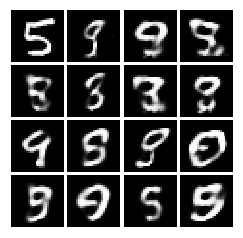

Iter: 23000
Loss: 95.23
()


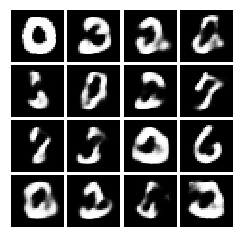

KeyboardInterrupt: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
mb_size = 64
z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = 28
h_dim = 128
lr = 1e-3


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


# =============================== Q(z|X) ======================================

X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, y_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

Q_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, c):
    inputs = tf.concat(axis=1, values=[X, c])
    h = tf.nn.relu(tf.matmul(inputs, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim + y_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    h = tf.nn.relu(tf.matmul(inputs, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits


# =============================== TRAINING ====================================

z_mu, z_logvar = Q(X, c)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample, c)

# Sampling from random z
X_samples, _ = P(z, c)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer().minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())


for it in range(1000000):
    X_mb, _ = mnist.train.next_batch(mb_size)
    y_mb= [np.reshape(np.reshape(T,(28,28))[:,13],(28,)) for T in X_mb]
    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb, c: y_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()
        
        img =mnist.test.images[np.random.randint(0,9999)]
        y1 = np.reshape(np.reshape(img,(28,28))[:,13],(28,)) 
        y = np.zeros(shape=[16, y_dim])
        for ind in range(16):
            y[ind, :] = y1

        samples = sess.run(X_samples,
                           feed_dict={z: np.random.randn(16, z_dim), c: y})
        
        samples[0]=img

        fig = plot(samples)
        plt.show()
        plt.close(fig)